In [1]:
import pandas as pd
import os
import json

data_dir = '../data/hotpotqa-fullwiki/'
file_names = ['hotpot_dev_fullwiki_v1.json', 'hotpot_train_v1.1.json']
data_list = []

def count_words(sentences):
    return sum(len(sentence.split()) for sentence in sentences)

for file_name in file_names:
    file_path = os.path.join(data_dir, file_name)
    with open(file_path, 'r') as f:
        json_data = json.load(f)
        for item in json_data:
            answer = item["answer"]
            question = item["question"]
            question_id = item["_id"]
            
            supporting_facts = item["supporting_facts"]
            context_list = []
            for context in item["context"]:
                context_list.extend(context[1])
                
            data_list.append({
                "Answer": answer,
                "Question": question,
                "QuestionId": question_id,
                "SupportingFacts": supporting_facts,
                "Context": context_list
            })

df = pd.DataFrame(data_list)
df

,Answer,Question,QuestionId,SupportingFacts,Context
0,yes,Were Scott Derrickson and Ed Wood of the same ...,5a8b57f25542995d1e6f1371,"[[Scott Derrickson, 0], [Ed Wood, 0]]",[Adam Collis is an American filmmaker and acto...
1,Chief of Protocol,What government position was held by the woman...,5a8c7595554299585d9e36b6,"[[Kiss and Tell (1945 film), 0], [Shirley Temp...",[A Kiss for Corliss is a 1949 American comedy ...
2,Animorphs,"What science fantasy young adult series, told ...",5a85ea095542994775f606a8,"[[The Hork-Bajir Chronicles, 0], [The Hork-Baj...",[Animorphs is a science fantasy series of youn...
3,no,Are the Laleli Mosque and Esma Sultan Mansion ...,5adbf0a255429947ff17385a,"[[Laleli Mosque, 0], [Esma Sultan Mansion, 0]]",[Esma Sultan is the name of three daughters of...
4,"Greenwich Village, New York City","The director of the romantic comedy ""Big Stone...",5a8e3ea95542995a26add48d,"[[Big Stone Gap (film), 0], [Adriana Trigiani,...","[Great Eastern Conventions, Inc. was an entert..."
...,...,...,...,...,...
97847,American,Kerry Remsen is the daughter of an actor with ...,5a8f8db25542997ba9cb32b9,"[[Kerry Remsen, 1], [Bert Remsen, 0]]","[Kerry Remsen is an American actress., She is..."
97848,Simon Property Group,"Who manages both Northshore Mall in Peabody, M...",5ae4f3615542993aec5ec0fd,"[[Northshore Mall, 0], [Northshore Mall, 4], [...",[Green Tree Mall is a shopping mall located in...
97849,Amblin Partners,Charlee Johnson was part of a band that signed...,5a903fc95542990a984935bd,"[[Charlee Johnson, 4], [DreamWorks, 0]]",[Simon M. Woods is a British entrepreneur and ...
97850,"MV ""Wilhelm Gustloff",What is the ship that sank in the Baltic sea a...,5ab56e71554299494045efc8,"[[Salt to the Sea, 1], [MV Wilhelm Gustloff, 0]]",[The I.V. Stalin White Sea – Baltic Sea Canal ...


In [2]:
num_questions = df.shape[0]

df['QuestionLength'] = df['Question'].apply(lambda x: len(x.split()))
avg_question_length = df['QuestionLength'].mean()
std_question_length = df['QuestionLength'].std()

df['NumContexts'] = df['Context'].apply(lambda x: len(x))
num_contexts = df['NumContexts'].sum()

df['ContextLength'] = df['Context'].apply(lambda x: count_words(x))
avg_context_length = df['ContextLength'].mean()
std_context_length = df['ContextLength'].std()

df['AnswerLength'] = df['Answer'].apply(lambda x: len(x.split()))
avg_answer_length = df['AnswerLength'].mean()
std_answer_length = df['AnswerLength'].std()

print(f"Number of questions: {num_questions}")
print(f"Average question length: {avg_question_length:.2f} words")
print(f"Standard deviation of question length: {std_question_length:.2f} words")
print(f"Number of contexts (facts): {num_contexts}")
print(f"Average context length: {avg_context_length:.2f} words")
print(f"Standard deviation of context length: {std_context_length:.2f} words")
print(f"Average golden answer length: {avg_answer_length:.2f} words")
print(f"Standard deviation of golden answer length: {std_answer_length:.2f} words")

Number of questions: 97852
Average question length: 17.66 words
Standard deviation of question length: 9.29 words
Number of contexts (facts): 4017967
Average context length: 888.86 words
Standard deviation of context length: 252.84 words
Average golden answer length: 2.24 words
Standard deviation of golden answer length: 1.81 words


In [2]:
import nltk
from collections import Counter
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm

nltk.download('punkt')

def get_top_ngrams(questions, n, top_k=32):
    ngram_counter = Counter()
    for question in questions:
        tokens = nltk.word_tokenize(question.lower())
        ngram_counter.update(ngrams(tokens, n))
    return ngram_counter.most_common(top_k)

questions = df['Question'].tolist()

df_ngram = pd.DataFrame(columns=[f'rank-{i+1}' for i in range(32)], index=[f'{i+1}-gram' for i in range(8)])

for n in tqdm(range(1, 9), desc="Processing n-grams"):
    top_ngrams = get_top_ngrams(questions, n)
    for rank, (ngram, freq) in enumerate(top_ngrams):
        ngram_str = ' '.join(ngram)
        df_ngram.at[f'{n}-gram', f'rank-{rank+1}'] = (ngram_str, freq)
    print(f"Top {n}-grams: {top_ngrams[:5]}")
    df_ngram.to_csv('top_ngrams.csv', index=True)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/yuehengzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processing n-grams:   0%|          | 0/8 [00:00<?, ?it/s]

Top 1-grams: [(('the',), 118274), (('?',), 95628), ((',',), 65380), (('of',), 60572), (('in',), 55147)]
Top 2-grams: [(('of', 'the'), 20434), (('in', 'the'), 12097), (('is', 'the'), 10843), (('was', 'the'), 9779), (('is', 'a'), 7924)]
Top 3-grams: [(('what', 'is', 'the'), 4830), (('in', 'what', 'year'), 3253), (('what', 'year', '?'), 2207), (('name', 'of', 'the'), 2106), (('the', 'name', 'of'), 2070)]
Top 4-grams: [(('in', 'what', 'year', '?'), 2014), (('is', 'the', 'name', 'of'), 1603), (('what', 'is', 'the', 'name'), 1600), (('the', 'name', 'of', 'the'), 1538), (('have', 'in', 'common', '?'), 1355)]
Top 5-grams: [(('what', 'is', 'the', 'name', 'of'), 1576), (('is', 'the', 'name', 'of', 'the'), 1181), (('in', 'what', 'year', 'was', 'the'), 714), (('born', 'in', 'what', 'year', '?'), 513), (('who', 'was', 'born', 'first', ','), 410)]
Top 6-grams: [(('what', 'is', 'the', 'name', 'of', 'the'), 1169), (('what', 'is', 'the', 'nationality', 'of', 'the'), 301), (('what', 'was', 'the', 'name'

/tmp/ipykernel_2820493/3794144559.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2820493/3794144559.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2820493/3794144559.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2820493/3794144559.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2820493/3794144559.py:32: UserWarning: set_ticklabels() should on

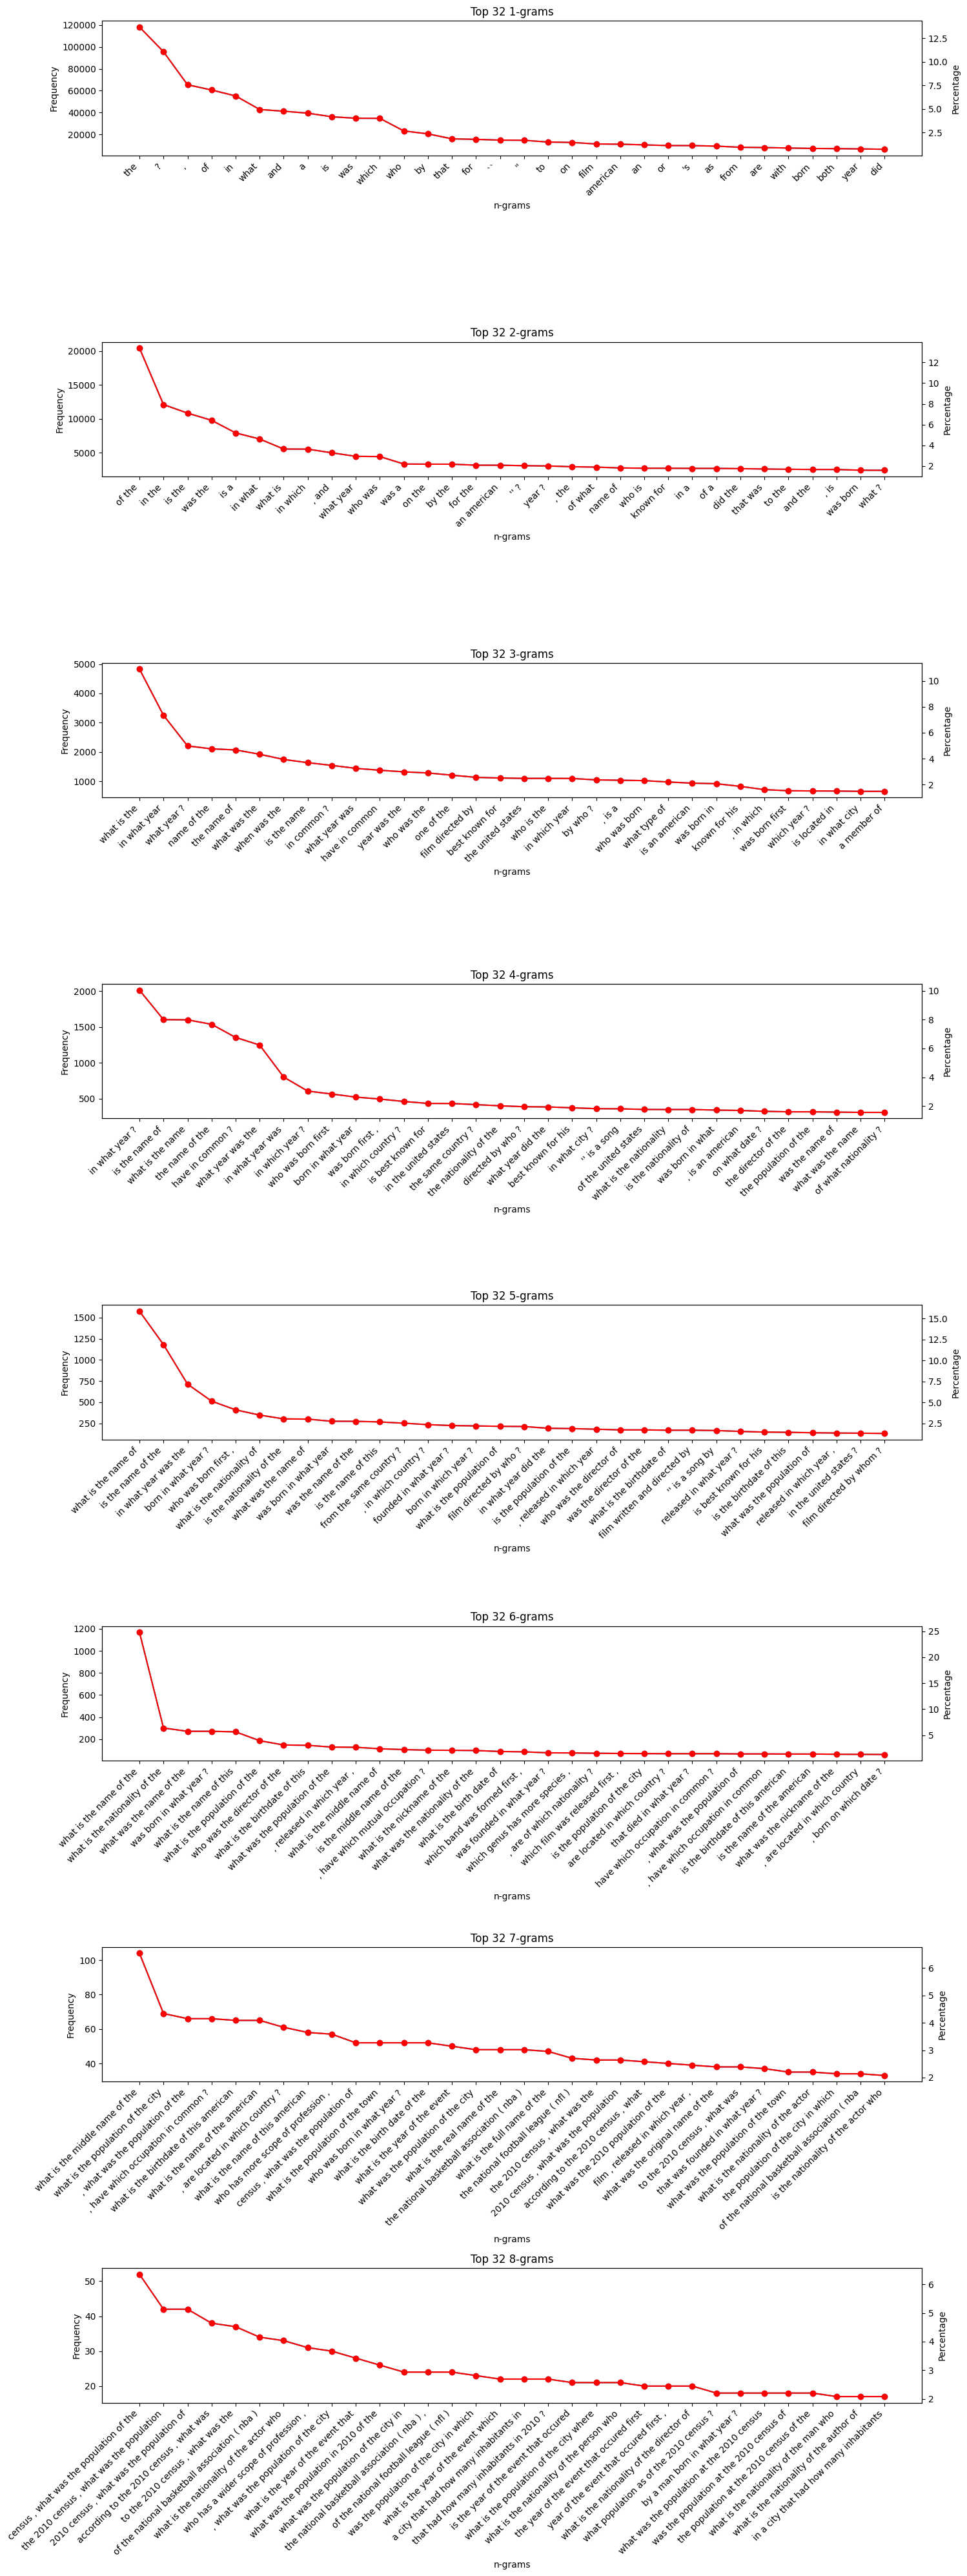

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df_ngram = pd.read_csv('top_ngrams.csv', index_col=0)
def parse_ngram_freq(cell):
    if isinstance(cell, str):
        ngram, freq = eval(cell)
        return ngram, freq
    return None, 0

fig, axs = plt.subplots(8, 1, figsize=(15, 40))

for i in range(8):
    n = i + 1
    ngram_labels = []
    frequencies = []
    
    for col in df_ngram.columns:
        ngram, freq = parse_ngram_freq(df_ngram.at[f'{n}-gram', col])
        if ngram:
            ngram_labels.append(ngram)
            frequencies.append(freq)

    total_freq = sum(frequencies)
    ratios = [freq / total_freq * 100 for freq in frequencies]
    
    ax1 = axs[i]
    ax1.plot(ngram_labels, frequencies, marker='o', label='Frequency')
    ax1.set_title(f'Top 32 {n}-grams')
    ax1.set_xlabel('n-grams')
    ax1.set_ylabel('Frequency')
    ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
    
    ax2 = ax1.twinx()
    ax2.plot(ngram_labels, ratios, marker='o', color='r', label='Percentage')
    ax2.set_ylabel('Percentage')

plt.tight_layout()
plt.show()